## TrainDataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import torch

from src.data.kitti.dataset import KITTIDataset
from src.data.patch_dataset.dataset import PatchDataset
from src.data.kitti.utils import image_torch2np
from src.data.kitti.utils import depth_torch2np
from src.data.patch_dataset.utils import get_patch_size
from src.data.kitti.utils import depth2cloud
from src.data.kitti.utils import cloud2depth
from src.model.DepthNet import DepthNet

In [37]:
kitti = KITTIDataset('val', center_crop=False)

N = 100
base_size = (100, 100)
out_size = (300, 300)
print(out_size)

data_warp = PatchDataset(
    kitti_dataset=kitti,
    base_size=base_size,
    scale=2,
    num_scales=3,
    scaling_factor=1.5,
    out_size=out_size,
    sampling_strategy='grid',
    max_num_samples_per_image=N,
    preserve_camera=True,
    return_descriptors=True,
)

data_crop = PatchDataset(
    kitti_dataset=kitti,
    base_size=base_size,
    scale=2,
    num_scales=3,
    scaling_factor=1.5,
    out_size=out_size,
    sampling_strategy='grid',
    max_num_samples_per_image=N,
    preserve_camera=False,
    return_descriptors=True,
)
#grid_data = PatchDataset(kitti_dataset=kitti, aspect_ratio=aspect_ratio, out_size=out_size, sampling_strategy='grid', max_num_samples_per_image=N, preserve_camera=True, return_descriptors=True)
#corner_data = PatchDataset(kitti_dataset=kitti, aspect_ratio=aspect_ratio, out_size=out_size, sampling_strategy='corner', max_num_samples_per_image=N, preserve_camera=True, return_descriptors=True)

(300, 300)


In [15]:
from src.data.patch_dataset.patch_descriptor import PatchDescriptor
from src.data.patch_dataset.utils import get_transformation

def get_patch(data: PatchDataset, idx_image: int, idx_patch: int):

    image, camera, gt_depth, velo_depth = data.kitti_dataset[idx_image]
    gt_point_cloud: np.ndarray = depth2cloud(gt_depth, camera)
    velo_point_cloud: np.ndarray = depth2cloud(velo_depth, camera)

    XY = data.sampling_strategy(-1, image, camera, data.base_size, data.scale, data.num_scales, data.scaling_factor)

    H, W, _ = image.shape

    XY = np.vstack([XY, np.array([[W // 2, H // 2]], dtype=np.int64)]) # Safe point

    num_valid = 0
    patch_descriptors: list[PatchDescriptor] = []

    for center_x, center_y in XY:
        original_size = get_patch_size(data.base_size, data.scale, data.scaling_factor)
        tform, patch_camera, scaling_factor = get_transformation(center_x, center_y, data.scale, original_size, camera, data.out_size)

        pd = PatchDescriptor(
            center_x=center_x,
            center_y=center_y,
            scale=data.scale,
            original_size=original_size,
            actual_size=data.out_size,
            scaling_factor=scaling_factor,
            camera=patch_camera,
            tform=tform,
        )
        pd.extract_from_image(image, gt_point_cloud, velo_point_cloud, gt_depth, velo_depth, data.preserve_camera)

        # Check if it has out-of-view pixels
        if pd.is_valid(image):
            patch_descriptors.append(pd)
            num_valid += 1

        if num_valid >= data.max_num_samples_per_image:
            break
    return patch_descriptors[idx_patch]

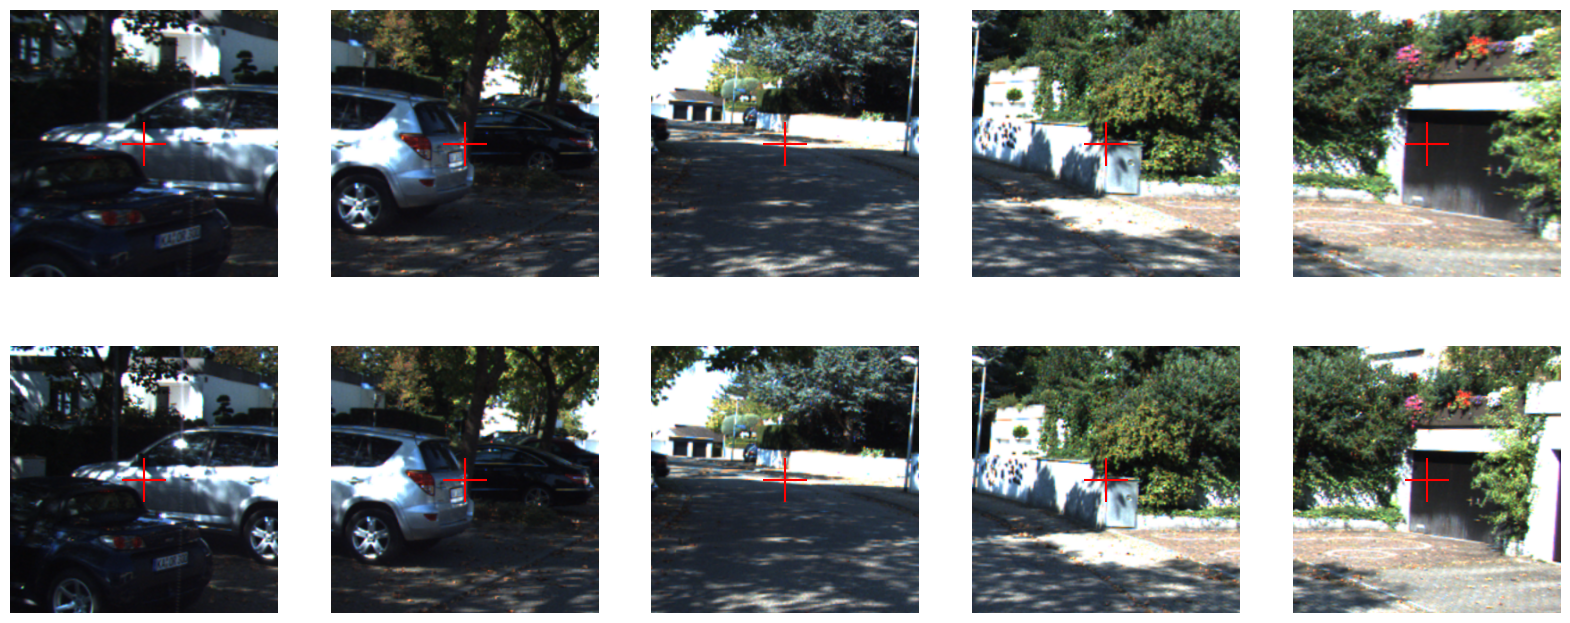

In [76]:
image_indexes = [27] * 5 # 34 37 27
patch_indexes = [0, 3, 6, 9, 12]


plt.subplots(nrows=2, ncols=len(image_indexes), figsize=(4*len(image_indexes), 4*2))

for i in range(len(image_indexes)):
    pd = get_patch(data_crop, image_indexes[i], patch_indexes[i])
    plt.subplot(2, len(image_indexes), i + 1)
    plt.axis('off')
    plt.imshow(pd.patch_image)
    plt.scatter(pd.actual_size[1] // 2, pd.actual_size[0] // 2, c=['r'], marker='+', s=1000)

    pd = get_patch(data_warp, image_indexes[i], patch_indexes[i])
    plt.subplot(2, len(image_indexes), len(image_indexes) + (i + 1))
    plt.axis('off')
    plt.imshow(pd.patch_image)
    plt.scatter(pd.actual_size[1] // 2, pd.actual_size[0] // 2, c=['r'], marker='+', s=1000)

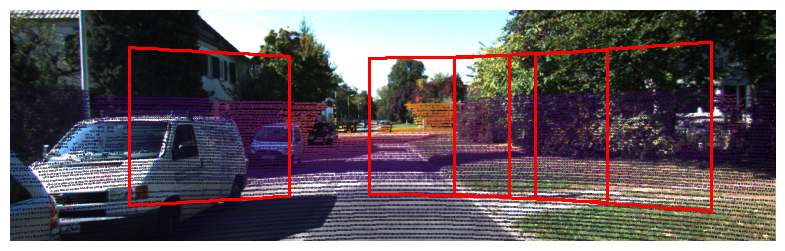

In [9]:
idx = 10
image, camera, gt_depth, velo_depth = kitti[idx]
batch_patch_image, batch_patch_gt_depth, batch_patch_velo_depth, patch_descriptors = data_warp[idx]

valid = (velo_depth > 0)
z = velo_depth[valid]
y, x = np.where(valid)

patch_rr = []
patch_cc = []
for pd in patch_descriptors:
    coords = pd.get_original_coords()
    rr, cc = skimage.draw.polygon_perimeter(coords[:, 1], coords[:, 0])
    patch_rr.append(rr)
    patch_cc.append(cc)
patch_rr = np.concatenate(patch_rr, axis=0)
patch_cc = np.concatenate(patch_cc, axis=0)

plt.figure(figsize=(12, 3))
plt.axis('off')
plt.imshow(image)
plt.scatter(x, y, c=z, cmap='inferno', s=0.1, vmin=kitti.min_depth, vmax=kitti.max_depth)
plt.scatter(patch_cc, patch_rr, c='red', s=1)

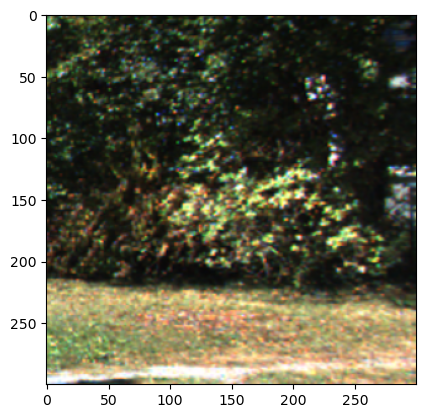

In [11]:
plt.imshow(image_torch2np(batch_patch_image[0]))

(46.99894, 64.11991)

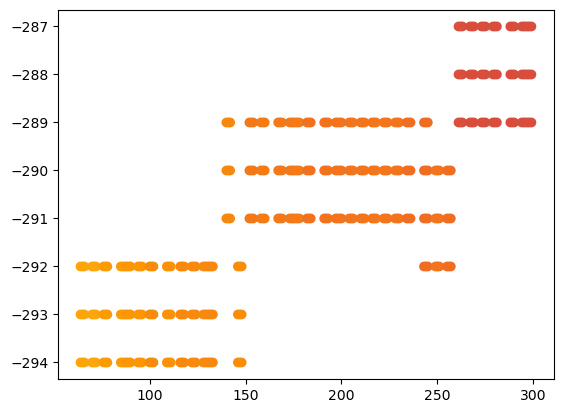

In [22]:
np_patch_velo_depth = depth_torch2np(batch_patch_velo_depth[0])
valid = (np_patch_velo_depth > 0)
z = np_patch_velo_depth[valid]
y, x = np.where(valid)

plt.scatter(x, -y, c=z, cmap='inferno', vmin=1e-3, vmax=80)
z.min(), z.max()

(46.971962, 64.261475)

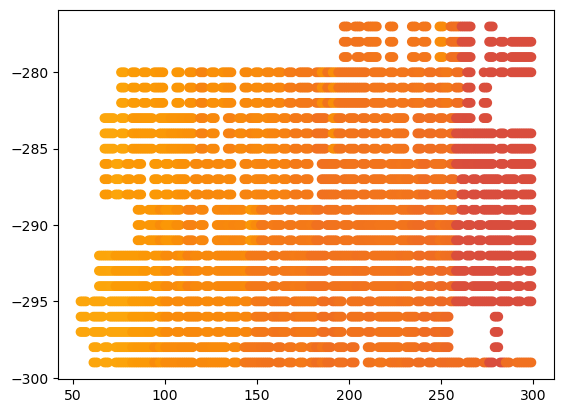

In [18]:
np_patch_gt_depth = depth_torch2np(batch_patch_gt_depth[0])
valid = (np_patch_gt_depth > 0)
z = np_patch_gt_depth[valid]
y, x = np.where(valid)

plt.scatter(x, -y, c=z, cmap='inferno', vmin=1e-3, vmax=80)
z.min(), z.max()

In [26]:
pd = patch_descriptors[1]
# Get initial image coords
x: np.ndarray = np.linspace(0., float(gt_depth.shape[1] - 1), gt_depth.shape[1], dtype=np.int64)
y: np.ndarray = np.linspace(0., float(gt_depth.shape[0] - 1), gt_depth.shape[0], dtype=np.int64)

grid_x, grid_y = np.meshgrid(x, y, indexing='xy')

x = grid_x.flatten()
y = grid_y.flatten()

z: np.ndarray = gt_depth[y, x]

valid = (z > 0)
x_img = x[valid]
y_img = y[valid]

# roto-translate point cloud
xyz_cam_rototranslated = depth2cloud(gt_depth, camera) @ pd.camera.R.T + pd.camera.t.T

temp_gt_depth = gt_depth.copy()
temp_gt_depth[y_img, x_img] = xyz_cam_rototranslated[:, 2]

patch_gt_depth = skimage.transform.warp(temp_gt_depth, pd.tform.inverse, output_shape=pd.actual_size, order=0, preserve_range=True) # dtype=np.float64

(6.189009, 6.843656)

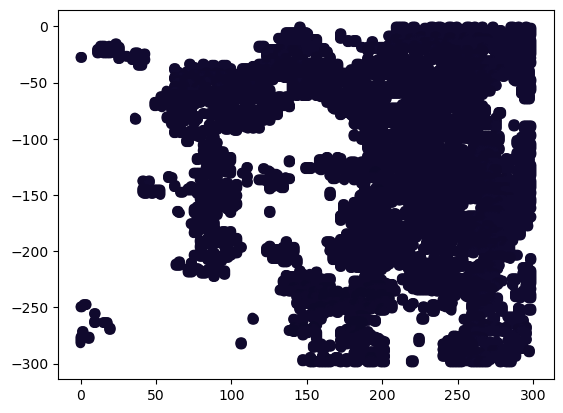

In [27]:
valid = (patch_gt_depth > 0)
z = patch_gt_depth[valid]
y, x = np.where(valid)

plt.scatter(x, -y, c=z, cmap='inferno', vmin=1e-3, vmax=80)
z.min(), z.max()

(5.15633, 6.088825)

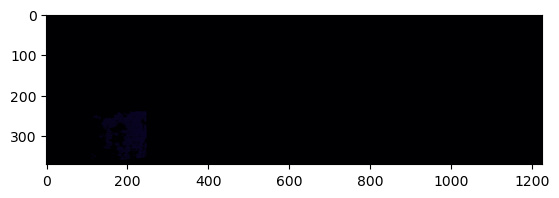

In [30]:
pd.patch_depth = patch_gt_depth
image_depth = pd.project_to_image(camera)

plt.imshow(image_depth, vmin=kitti.min_depth, vmax=kitti.max_depth, cmap='inferno')
valid = (image_depth > 0)
z = image_depth[valid]
y, x = np.where(valid)

plt.scatter(x, y, c=z, s=0.01, cmap='inferno', vmin=1e-3, vmax=80)
z.min(), z.max()

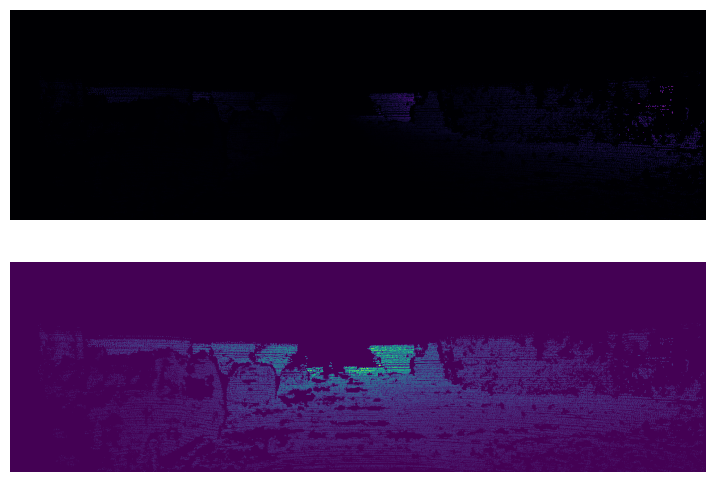

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(3*4, 3*2))

ax1.axis('off')
ax1.imshow((gt_depth - temp_gt_depth)**2, cmap='inferno')#, vmin=1e-3, vmax=80)

ax2.axis('off')
ax2.imshow(temp_gt_depth, vmin=1e-3, vmax=80)